Mean Squared Error: 0.0005
R^2 Score: 0.9956


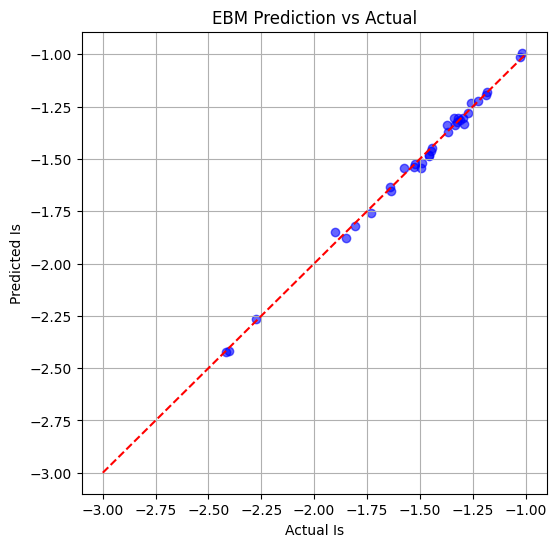

In [3]:
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load & prepare your data
df = pd.read_csv("LP drone data.csv")
df_split = df.iloc[:, 0].str.split(';', expand=True)
df_split.columns = [
    "dataset", "Altitude (m)", "Exposure time (sec)", "NSB (mpsas)",
    "Is", "Rs", "Gs", "Bs"
]
df_split = df_split.dropna()  # ensure no NaNs
df_split[["Altitude (m)", "Exposure time (sec)", "NSB (mpsas)", "Is", "Rs", "Gs", "Bs"]] = \
    df_split[["Altitude (m)", "Exposure time (sec)", "NSB (mpsas)", "Is", "Rs", "Gs", "Bs"]].astype(float)

# 2. Feature and target
X = df_split[["Altitude (m)", "Exposure time (sec)", "NSB (mpsas)", "Rs", "Gs", "Bs"]]
y = df_split["Is"]

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 4. Train EBM
ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X_train, y_train)

# 5. Predict and evaluate
y_pred = ebm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 6. Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.6)
plt.xlabel("Actual Is")
plt.ylabel("Predicted Is")
plt.title("EBM Prediction vs Actual")
plt.grid(True)
plt.plot([-3, -1], [-3, -1], 'r--')  # Line of perfect prediction
plt.show()

# 7. Show global explainability
from interpret import show
ebm_global = ebm.explain_global()
show(ebm_global)


In [4]:
from interpret import show
import numpy as np

# 1. Function to get user input and predict
def predict_light_pollution(ebm_model):
    print("\n--- Light Pollution Predictor ---")

    # Collect input from user
    altitude = float(input("Enter altitude (m): "))
    exposure_time = float(input("Enter exposure time (sec): "))
    nsb = float(input("Enter NSB (mpsas): "))
    rs = float(input("Enter Rs value: "))
    gs = float(input("Enter Gs value: "))
    bs = float(input("Enter Bs value: "))

    # Prepare input
    user_data = pd.DataFrame([{
        "Altitude (m)": altitude,
        "Exposure time (sec)": exposure_time,
        "NSB (mpsas)": nsb,
        "Rs": rs,
        "Gs": gs,
        "Bs": bs
    }])

    # Predict
    predicted_Is = ebm_model.predict(user_data)[0]

    # Explain the severity
    if predicted_Is > -1.0:
        severity = "High light pollution"
    elif predicted_Is > -1.8:
        severity = "Moderate light pollution"
    else:
        severity = "Low light pollution"

    print(f"\n🔮 Predicted Light Intensity (Is): {predicted_Is:.4f}")
    print(f"📊 Pollution Severity: {severity}")

    # Explain major contributing factor
    local_exp = ebm_model.explain_local(user_data, name="User Sample")
    scores = local_exp.data(0)['scores']
    features = local_exp.data(0)['names']
    top_feature = features[np.argmax(np.abs(scores))]
    top_contribution = scores[np.argmax(np.abs(scores))]

    print(f"\n🧠 Top Contributing Factor: {top_feature}")
    print(f"⚡ Impact on prediction: {top_contribution:+.4f}")

    # Visual explanation (optional if you're using Jupyter or Dash)
    show(local_exp)

# 2. Call the function
predict_light_pollution(ebm)



--- Light Pollution Predictor ---


KeyboardInterrupt: Interrupted by user